## Auxotrophic Growth of ADP1 ISx strains on Arginine
This is a revisit of analytical framework prompted by:
1. prep for the MBP MidTerm Progress Report
2. Keith's recent slack with some FoldIncrease calculations

### Quick Notes
- I've been approaching my calculations with the idea that two main functions should suffice for my theoretical modeling of Arg-aux growth:
    1. x_Arg(OD600_init, abundance_CGP_in_CDW, consts) 
    2. OD600(x_Arg, Yield_OD_from_x_Arg, consts)
- I've highlighted the differences from Keith's assumptions in values of constants
- I closely recapitulated Keith's fold increase calculations (11/05/2024)
- I realized that the `[Arg] from BM w/CGP` curves I've been using need a bit more explanation - at least graphically:
    - I'm using the OD600 scale for both OD600_init for `[Arg] from BM w/CGP` and OD600_final for the yield curves.
- I've been constructing the combined unit Yield as OD_phaseII from OD_phaseI, that naming is confusing because OD_phaseII is independent of OD_phaseI and is solely dependent on starting OD in phaseII and CGP(%CDW) from PhaseI.

In [77]:
from functools import partial

from IPython.display import display, Markdown

from sympy import symbols, Eq, plot, Function, N, Piecewise, solve
from sympy.physics.units.prefixes import micro
from sympy.physics.units import au, gram, liter, milliliter, mol

In [2]:
# numeric rounding to 3 sig figs
N3 = partial(N, n=3)

# additional units
molar = mol / liter
wv_perc = gram / (100 * milliliter)

In [3]:
# symbols (restricted to real values)
Real = partial(symbols, real=True)

# species
CGP, Arg, Asp, prot = Real('CGP, Arg, Asp, prot')

# abundances (mass ratios)
ab_Arg_in_prot = Real(r'abundance_{\frac{Arg}{prot}}')
ab_Arg_in_CGP = Real(r'abundance_{\frac{Arg}{CGP}}')
ab_Asp_in_CGP = Real(r'abundance_{\frac{Asp}{CGP}}')
ab_Arg_in_CDW = Real(r'abundance_{\frac{Arg}{CDW}}')
ab_CGP_in_CDW = Real(r'abundance_{\frac{CGP}{CDW}}')
ab_prot_in_CDW = Real(r'abundance_{\frac{prot}{CDW}}')
ab_CDW_per_OD600 = Real(r'ratio_{\frac{CDW}{OD600}}')

# masses
m_Arg, m_CGP, CDW = Real('m_{Arg}, m_{CGP}, CDW')

# molar weights
mw_Arg, mw_Asp = Real('mw_{Arg}, mw_{Asp}')

# concentrations (molar)
x = Real('x')
x_Arg = Real(r'x_{Arg}')
x_CGP = Real(r'x_{CGP}')

# optical density
OD, OD_initial, OD_delta = Real(r'OD600, OD600_{0}, OD600_{delta}')

# yields
Y_OD_from_x = Real(r'Y_{\frac{OD600}{x}}')
Y_OD_from_Arg_theor = Real(r'Y_{\frac{OD600}{Arg}_{theoretical}}')
Y_OD_from_Arg_exper = Real(r'Y_{\frac{OD600}{Arg}_{experimental}}')
Y_ODp2_from_ODp1 = Real(r'Y_{\frac{OD600_{phase2}}{OD600_{phase1}}}')
Y_CDWp2_from_CDWp1 = Real(r'Y_{\frac{CDW_{phase2}}{CDW_{phase1}}}')

# fold change (increase)
fold_chg_biomass = Real('FoldChange_{biomass}')

In [4]:
# FIXME - differs from Keith's assumptions

consts = {
    # molar weights
    mw_Arg: 174.2 * gram / mol,
    mw_Asp: 133.1 * gram / mol,

    # abundances
    ab_Arg_in_CGP: 0.60,  # FIXME accounting for one H2O loss 174.2 / (174.2 + 133.1 - 18)
    # ab_CGP_in_CDW: 0.10,  # working assumption (previously considered conservative)
    ab_Arg_in_prot: 0.05,  # 1/20 of all proteins (confirmed in cheminfo.ipynb)
    ab_prot_in_CDW: 0.50,  # 1/2 of cell dry weight presumed to be proteins

    # conversions FIXME based on https://bionumbers.hms.harvard.edu/bionumber.aspx?id=109838&ver=2 
    # ab_CDW_per_OD600: .33 * (gram / liter) / au,
    # based on https://link.springer.com/article/10.1007/s00253-019-09910-z 
    ab_CDW_per_OD600: .55 * (gram / liter) / au,
}

In [5]:
# linear relationship between OD600 (optical density) and x (molar concentration)
_eq_OD = Eq(OD, OD_delta + OD_initial)
eq_OD_delta = Eq(OD_delta, x * Y_OD_from_x)
eq_OD = _eq_OD.subs({OD_delta: eq_OD_delta.rhs})

display(_eq_OD, eq_OD_delta, eq_OD)

Eq(OD600, OD600_{0} + OD600_{delta})

Eq(OD600_{delta}, Y_{\frac{OD600}{x}}*x)

Eq(OD600, OD600_{0} + Y_{\frac{OD600}{x}}*x)

In [6]:
_eq_fold_diff = Eq(fold_chg_biomass, (OD_initial + OD_delta) / OD_initial)
eq_fold_diff = Eq(fold_chg_biomass, OD / OD_initial)

display(_eq_fold_diff, eq_fold_diff)

Eq(FoldChange_{biomass}, (OD600_{0} + OD600_{delta})/OD600_{0})

Eq(FoldChange_{biomass}, OD600/OD600_{0})

### Theoretical arginine demand by proteome (growth limiting)

This is a theoretical upper bound on arginine-auxotrophic growth, as we expect the highest priority for arginine utilization to be expression of the proteome.

In [7]:
eq_abundance_arg_cdw = Eq(ab_Arg_in_CDW, ab_prot_in_CDW * ab_Arg_in_prot)
consts[ab_Arg_in_CDW] = N3(eq_abundance_arg_cdw.rhs.subs(consts))

display(eq_abundance_arg_cdw, consts[ab_Arg_in_CDW])

Eq(abundance_{\frac{Arg}{CDW}}, abundance_{\frac{Arg}{prot}}*abundance_{\frac{prot}{CDW}})

0.0250

In [8]:
eq_Y_OD_from_arg = Eq(Y_OD_from_Arg_theor, mw_Arg / (ab_CDW_per_OD600 * ab_Arg_in_CDW))
_eq_Y_OD_from_arg_theor = N3(eq_Y_OD_from_arg.subs(consts))
consts[Y_OD_from_Arg_theor] = _eq_Y_OD_from_arg_theor.rhs

display(eq_Y_OD_from_arg, _eq_Y_OD_from_arg_theor)

Eq(Y_{\frac{OD600}{Arg}_{theoretical}}, mw_{Arg}/(abundance_{\frac{Arg}{CDW}}*ratio_{\frac{CDW}{OD600}}))

Eq(Y_{\frac{OD600}{Arg}_{theoretical}}, 1.27e+4*astronomical_unit*liter/mole)

In [9]:
(eq_OD_delta_x_Arg__theor := eq_OD_delta.subs({x: x_Arg, Y_OD_from_x: consts[Y_OD_from_Arg_theor]}))

Eq(OD600_{delta}, 1.27e+4*astronomical_unit*liter*x_{Arg}/mole)

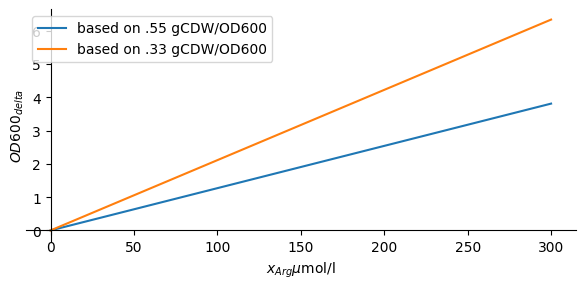

In [10]:
# plot of theoretical OD600 from x_Arg
# NOTE after we changed to .55 gCDW/OD600, the theoretical yield reduced, because we need more arginine to make the same amount of biomass. 
plot(
    # based on the more recent .55 gCDW/OD600 [gCDW/Liter/au] ratio
    eq_OD_delta_x_Arg__theor.rhs.subs(consts) * (micro * mol / liter) / au,
    # based on the older       .33 gCDW/OD600 [gCDW/Liter/au] ratio
    eq_OD_delta.rhs.subs({
        x: x_Arg,
        Y_OD_from_x: eq_Y_OD_from_arg.rhs.subs({ab_CDW_per_OD600: .33 * (gram / liter) / au}),
    }).subs(consts) * (micro * mol / liter) / au,
    (x_Arg, 0, 300),
    xlabel=x_Arg * micro * mol / liter,
    ylabel=OD_delta,
    label=(
        'based on .55 gCDW/OD600',
        'based on .33 gCDW/OD600',
    ),
    legend=True,
    size=(6, 3),
)

### Accumulated CGP as source of Arginine

ALE Phases with auxotrophic stains:

- Phase I - inoculation from pre-culture, growth and accumulation of CGP
- Phase II - inoculation from cultures from Phase I, growth limited by Arg from 

CGP is accumulated in Phase I and consumed in Phase II of ALE.

### Modeling x_Arg (arginine concentration) in the volume of culture medium

In [11]:
# we know how to estimate OD based on Arg concentration, so we need a function to predict Arg concentration
Function(x_Arg)(OD, ab_CGP_in_CDW)

x_{Arg}(OD600, abundance_{\frac{CGP}{CDW}})

In [12]:
eq_x_Arg_from_OD = Eq(x_Arg, OD * ab_CDW_per_OD600 * ab_CGP_in_CDW * ab_Arg_in_CGP / mw_Arg)
eq_x_Arg_from_OD

Eq(x_{Arg}, OD600*abundance_{\frac{Arg}{CGP}}*abundance_{\frac{CGP}{CDW}}*ratio_{\frac{CDW}{OD600}}/mw_{Arg})

In [13]:
eq_OD_of_x_Arg = eq_OD.subs({x: eq_x_Arg_from_OD.rhs.subs({OD: OD_initial})})
eq_fold_chg_biomass = Eq(fold_chg_biomass, (eq_OD_of_x_Arg.rhs / OD_initial).simplify())

display(
    eq_OD_of_x_Arg,
    Eq(eq_OD_of_x_Arg.lhs / OD_initial, (eq_OD_of_x_Arg.rhs / OD_initial).simplify()),
    Markdown('---'),
    Markdown('we can conclude that the fold change in not dependent on starting OD'),
    eq_fold_diff,
    eq_fold_chg_biomass,
    N3(eq_fold_chg_biomass.subs(consts)),
    Markdown('fold change depends on the **Yield of OD600 from Arginine** and **CGP (%CDW)**'),
)

Eq(OD600, OD600_{0}*Y_{\frac{OD600}{x}}*abundance_{\frac{Arg}{CGP}}*abundance_{\frac{CGP}{CDW}}*ratio_{\frac{CDW}{OD600}}/mw_{Arg} + OD600_{0})

Eq(OD600/OD600_{0}, (Y_{\frac{OD600}{x}}*abundance_{\frac{Arg}{CGP}}*abundance_{\frac{CGP}{CDW}}*ratio_{\frac{CDW}{OD600}} + mw_{Arg})/mw_{Arg})

---

we can conclude that the fold change in not dependent on starting OD

Eq(FoldChange_{biomass}, OD600/OD600_{0})

Eq(FoldChange_{biomass}, (Y_{\frac{OD600}{x}}*abundance_{\frac{Arg}{CGP}}*abundance_{\frac{CGP}{CDW}}*ratio_{\frac{CDW}{OD600}} + mw_{Arg})/mw_{Arg})

Eq(FoldChange_{biomass}, 0.00574*mole*(174.0*gram/mole + 0.33*gram*Y_{\frac{OD600}{x}}*abundance_{\frac{CGP}{CDW}}/(astronomical_unit*liter))/gram)

fold change depends on the **Yield of OD600 from Arginine** and **CGP (%CDW)**

In [18]:
# lower bound on x_Arg from 0.05 OD and 10 CGP(%CDW) (realistic)
# N3(eq_x_Arg_from_OD.subs({OD: .05 * au, ab_CGP_in_CDW: 0.10}).subs(consts))

In [19]:
# upper bound on x_Arg from 0.20 OD and 60 CGP(%CDW) (supremely optimistic)
# N3(eq_x_Arg_from_OD.subs({OD: .20 * au, ab_CGP_in_CDW: 0.60}).subs(consts))

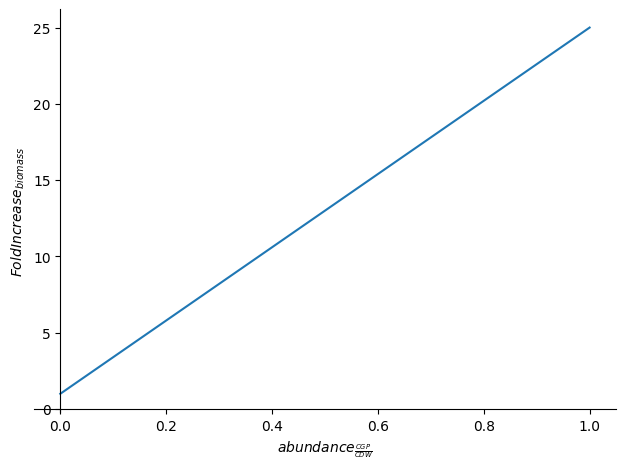

In [20]:
# plot FoldChange_OD600 over CGP(%CDW) :: should be equivalent to Keith's gCDW, since linearly related
plot(
    eq_fold_chg_biomass.rhs.subs({Y_OD_from_x: consts[Y_OD_from_Arg_theor]}).subs(consts),
    (ab_CGP_in_CDW, 0, 1),
    ylabel=symbols('FoldIncrease_{biomass}'),
)

### Experimental Results

In [49]:
# exp007 - ∆argBR ∆astA
N3(eq_OD_delta_x_Arg__exp007_KSF230 := Eq(OD_delta, .976 / 2000 * x_Arg))

Eq(OD600_{delta}, 0.000488*x_{Arg})

In [50]:
# exp008 - KSF107+ {∆argB ∆astA ∆cphAI} 
N3(eq_OD_delta_x_Arg__exp008_KSF107 := Eq(OD_delta, Piecewise(
    # pre-saturation
    (.174 / 50 * x_Arg, x_Arg <= 50),
    # post-saturation
    (.174, x_Arg > 50),
)))

Eq(OD600_{delta}, Piecewise((0.00348*x_{Arg}, x_{Arg} <= 50), (0.174, True)))

In [63]:
# exp011 - ∆argBR ∆astA ∆cphAI
Y_OD_from_Arg_exp011_KSF111 = .446 / 50 * 1e6 * au * liter / mol

N3(eq_OD_delta_x_Arg__exp011_KSF111 := Eq(OD_delta, Piecewise(
    # pre-saturation
    (Y_OD_from_Arg_exp011_KSF111 * 1e-6 * mol / au / liter * x_Arg, x_Arg <= 50),
    # post-saturation
    (.446, x_Arg > 50),
)))

Eq(OD600_{delta}, Piecewise((0.00892*x_{Arg}, x_{Arg} <= 50), (0.446, True)))

In [64]:
# exp011 - KSF001 wild-type
N3(eq_OD_delta_x_Arg__exp011_KSF001 := Eq(OD_delta, .428 / 300 * x_Arg))

Eq(OD600_{delta}, 0.00143*x_{Arg})

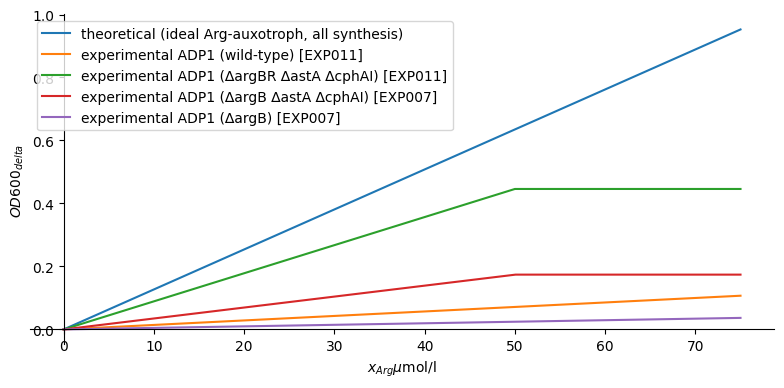

In [65]:
plot(
    # theoretical
    eq_OD_delta_x_Arg__theor.subs(consts).rhs * (micro * mol / liter) / au,
    # exp011
    eq_OD_delta_x_Arg__exp011_KSF001.rhs,  # KSF001 - wild-type
    eq_OD_delta_x_Arg__exp011_KSF111.rhs,  # KSF111 - ∆argBR ∆astA ∆cphAI
    # exp008
    eq_OD_delta_x_Arg__exp008_KSF107.rhs,  # KSF107 - ∆argB ∆astA ∆cphAI
    # exp007 (KSF230 - ∆argB ∆cphAI)
    eq_OD_delta_x_Arg__exp007_KSF230.rhs,  # KSF230 - ∆argB

    # arginine concentration range
    (x_Arg, 0, 75),

    # plot options
    xlabel=x_Arg * micro * mol / liter,
    ylabel=OD_delta,
    label=(
        'theoretical (ideal Arg-auxotroph, all synthesis)',
        'experimental ADP1 (wild-type) [EXP011]',
        'experimental ADP1 (∆argBR ∆astA ∆cphAI) [EXP011]',
        'experimental ADP1 (∆argB ∆astA ∆cphAI) [EXP007]',
        'experimental ADP1 (∆argB) [EXP007]',
    ),
    legend=True,
    size=(8, 4),
)

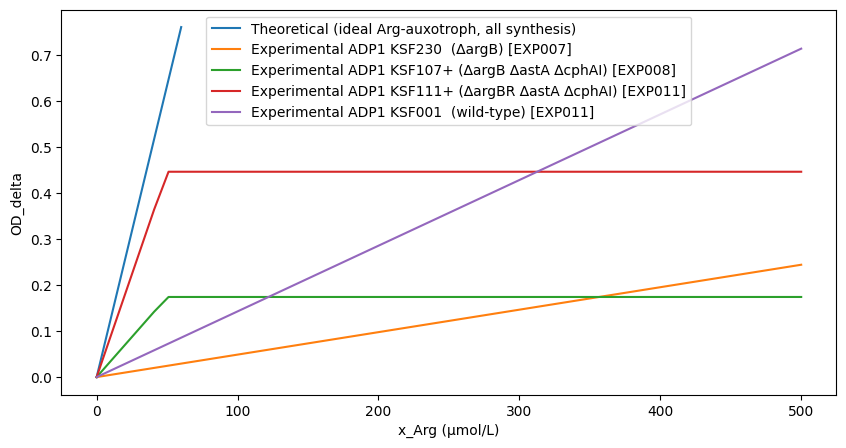

In [66]:
import matplotlib.pyplot as plt
import numpy as np

# Define x-axis values for different ranges
x_theor = np.linspace(0, 60, 50)  # Narrower range for theoretical
x_exp = np.linspace(0, 500, 50)  # Wider range for experimental data

# Substitute values and evaluate functions for plotting
y_theor = [eq_OD_delta_x_Arg__theor.subs(consts).rhs.evalf(subs={x_Arg: val}) * (micro * mol / liter) / au for val in
           x_theor]
y_exp_KSF001 = [eq_OD_delta_x_Arg__exp011_KSF001.rhs.evalf(subs={x_Arg: val}) for val in x_exp]
y_exp_KSF111 = [eq_OD_delta_x_Arg__exp011_KSF111.rhs.evalf(subs={x_Arg: val}) for val in x_exp]
y_exp_KSF107 = [eq_OD_delta_x_Arg__exp008_KSF107.rhs.evalf(subs={x_Arg: val}) for val in x_exp]
y_exp_KSF230 = [eq_OD_delta_x_Arg__exp007_KSF230.rhs.evalf(subs={x_Arg: val}) for val in x_exp]

# Plot each curve with its designated range
plt.figure(figsize=(10, 5))
plt.plot(x_theor, y_theor, label='Theoretical (ideal Arg-auxotroph, all synthesis)')
plt.plot(x_exp, y_exp_KSF230, label='Experimental ADP1 KSF230  (∆argB) [EXP007]')
plt.plot(x_exp, y_exp_KSF107, label='Experimental ADP1 KSF107+ (∆argB ∆astA ∆cphAI) [EXP008]')
plt.plot(x_exp, y_exp_KSF111, label='Experimental ADP1 KSF111+ (∆argBR ∆astA ∆cphAI) [EXP011]')
plt.plot(x_exp, y_exp_KSF001, label='Experimental ADP1 KSF001  (wild-type) [EXP011]')

# Set labels, legend, and show plot
plt.xlabel("x_Arg (µmol/L)")
plt.ylabel("OD_delta")
plt.legend()
plt.show()

### Designing the ALE POC experiment

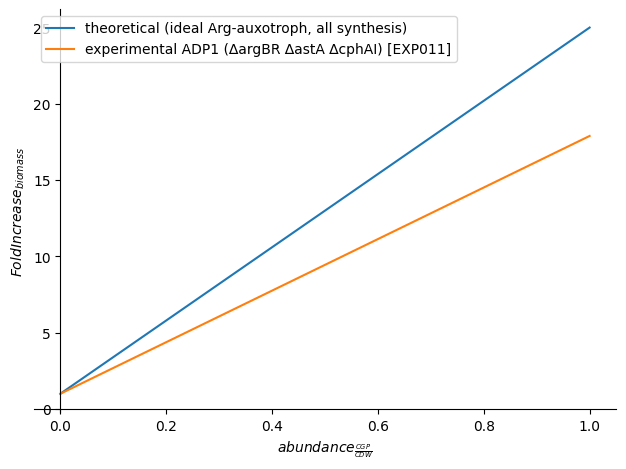

In [72]:
plot(
    # theoretical
    eq_fold_chg_biomass.rhs.subs({Y_OD_from_x: consts[Y_OD_from_Arg_theor]}).subs(consts),
    # KSF011 from exp011
    eq_fold_chg_biomass.rhs.subs({Y_OD_from_x: Y_OD_from_Arg_exp011_KSF111}).subs(consts),
    (ab_CGP_in_CDW, 0, 1),
    ylabel=symbols('FoldIncrease_{biomass}'),
    legend=True,
    label=(
        'theoretical (ideal Arg-auxotroph, all synthesis)',
        'experimental ADP1 (∆argBR ∆astA ∆cphAI) [EXP011]',
    ),
)

In [71]:
# proposed loading (need much higher starting OD of .1 au if we assume the most conservative 10% CGP.
# FIXME this is where we really need a good model and assumptions for x_Arg from cells with CGP
x_Arg_exp_ALE_POC = N3(eq_x_Arg_from_OD.subs({OD: .2 * au, ab_CGP_in_CDW: 0.15}).subs(consts))
x_Arg_exp_ALE_POC

Eq(x_{Arg}, 5.68e-5*mole/liter)

In [74]:
# fold change KSF111 + ∆astB
eq_fold_chg_biomass.rhs.subs({Y_OD_from_x: Y_OD_from_Arg_exp011_KSF111}).subs(consts).subs({ab_CGP_in_CDW: 0.15})

3.53467278989667

In [92]:
# 3.5-fold is high enough to proceed with ALE, but I do need a better measurement of ab_CGP_in_CDW
display(
    Markdown('experimental'),
    solve(eq_fold_diff.subs({OD_initial: .1 * au, fold_chg_biomass: 3.5}), OD / au),
    Markdown('---'),
    Markdown('background'),
    solve(eq_fold_diff.subs({OD_initial: .1 * au, fold_chg_biomass: 1.7}), OD / au),
)

experimental

[0.350000000000000]

---

background

[0.170000000000000]